In [27]:
import time
import typing as t

import numpy as np
import networkx as nx
import scipy.sparse as sp

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from gensim.models import Word2Vec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# INF 554 Lab 9: Deep Learning for Graph-Structured Data


We want to acknowledge _Prof. Giannis Nikolentzos_ for his large contributions to the content of this lab.

In this lab we will be working with the DeepWalk algorithm, an unsupervised method for the embedding of nodes in a  graph, and Graph Neural Networks, which are semi-supervised methods used for node classification and several other tasks on attributed graphs. Semi-supervised learning methods are trained on datasets, which include both labeled and unlabeled data points, and therefore are often said to fall inbetween supervised and unsupervised learning methods. 



### The Dataset

In this lab we will be working with a real dataset, called the _CORA_ dataset. It contains information on  2708 scientific publications in the area of Machine Learning. Each publication is represented by a node in our graph. If one of these publications cites another in the dataset then the two corresponding nodes in the graph are linked by an undirected edge; this gives rise to 5429 edges. Each publication furthermore has a 1433-dimensional feature vector attached to it. This feature vector takes values in $\{0,1\}^{1433}$ and encodes the absence/presence of a given set of keywords from the abstract of these publications. 

The publications contained in our dataset are split into 7 topics. The most common learning task on the Cora dataset is the classification of publications, i.e., nodes, into these 7 topics. In the past 5 years this dataset has attracted a very large amount of research interest to the extend where it is sometimes referred to as "the MNIST of Graph Learning." In 2019 the Cora dataset was rightfully criticised as being too small to distinguish the quality of machine learning approaches on its own. However, it continues to be included in a large number of papers as a standard benchmark dataset. So, it is a good dataset to get familiar with. 


We begin by loading the data you will be working with in this assessment. 



In [28]:
def load_data(path="cora/", dataset="cora"):
    """Load citation network dataset"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    features = features.todense()
    features /= features.sum(1).reshape(-1, 1)
    labels = idx_features_labels[:, -1]
    labels_numeric = LabelEncoder().fit_transform(idx_features_labels[:, -1])    
    print('Detected Class Labels:\t', set(idx_features_labels[:, -1]))

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    print(idx)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset), dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    print('Dataset has {} nodes, {} edges, {} features.\nDataset loaded successfully!'.format(adj.shape[0], edges.shape[0], features.shape[1]))

    return features, adj, labels, labels_numeric

# Read data
features, cora_adjacency, class_labels, class_labels_numeric = load_data()
G=nx.from_numpy_array(cora_adjacency)
n = G.number_of_nodes()
n_class = len(np.unique(class_labels)) # Number of classes


# Yields indices to split data into training, validation and test sets
np.random.seed(1)
idx = np.random.permutation(n)
idx_train = idx[:int(0.6*n)]
idx_val = idx[int(0.6*n):int(0.8*n)]
idx_test = idx[int(0.8*n):]

idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)
features = torch.FloatTensor(features).to(device)
class_labels_numeric = torch.LongTensor(class_labels_numeric).to(device)


class_labels_train = class_labels_numeric[idx_train]
class_labels_validation = class_labels_numeric[idx_val]
class_labels_test = class_labels_numeric[idx_test]

Loading cora dataset...
Detected Class Labels:	 {'Genetic_Algorithms', 'Case_Based', 'Neural_Networks', 'Theory', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning'}
[  31336 1061127 1106406 ... 1128978  117328   24043]
Dataset has 2708 nodes, 5429 edges, 1433 features.
Dataset loaded successfully!


## 1) The DeepWalk algorithm

The [DeepWalk algorithm](https://arxiv.org/pdf/1403.6652.pdf) was recently proposed for generating node embeddings, i.e., for mapping nodes of a graph to vectors in $\mathbb{R}^p.$ The dimension $p$ is a hyperparameter of the DeepWalk algorithm. 


The DeepWalk algorithm capitalises on recent advances in unsupervised feature learning which have proven very successful in Natural Language Processing (NLP). It can be described as a two stage procedure. In the first stage a series of random walks is performed on the graph to represent the graph structure. Then in the second stage, this collection of random walks is processed by a Word2Vec Skip-Gram model from NLP to obtain the node embeddings.

We begin by asking you to implement the first stage of the DeepWalk algorithm.


>**Task 1:** Fill in the body of the below ``random_walk()`` and ``generate_walks()`` functions. 
>1.  The ``random_walk()`` function should, given a graph and a starting vertex, perform a random walk of specific length, and return a list of strings indicating the visited vertices (_Hint:_ note that $G$ is a NexworkX graph. Therefore, you can use the function ``list(G.neighbors(v))`` to obtain the neighbors of a vertex $v$.)
>2. The ``generate_walks``function should run a number of random walks from each node of a graph, and return a list of all the simulated random walks, i.e., a list of lists. Please permute the list of walks after it has been generated, so as to not imbue unneccesary structure in the list of walks. 

In [29]:
def random_walk(
        G: nx.Graph,
        node: int,
        walk_length: int
    ) -> t.List[str]:
    """Simulates a random walk of length `walk_length` starting from node `node`.
    
    Returns a list of length (walk_length + 1) whose first element is str(node)."""

    walk = [str(node)]
    for i in range(walk_length):
        neighbors = list(G.neighbors(node))
        chosen = np.random.choice(a = neighbors, size = 1)[0]
        walk.append(str(chosen))
        node = chosen
    
    return walk

print('An example of a random walk is:', random_walk(G,0,5))

An example of a random walk is: ['0', '14', '242', '14', '232', '268']


The DeepWalk algorithm does not start only a single walk from each node, but several of them.
Then, these walks can be thought of as short sentences in some special language, and can be passed on to the Skipgram model.
 

In [30]:
def generate_walks(
        G: nx.Graph,
        num_walks: int,
        walk_length: int
    ) -> t.List[t.List[str]]:
    """Runs "num_walks" random walks from each node.
    
    Returns a list of length len(G.nodes)*num_walks. Each element is a random walk of length (walk_length + 1)"""

    walks = []

    for i in range(n):
        for j in range(num_walks):
            walks.append(random_walk(G, i, walk_length))
    
    permuted_walks = np.random.permutation(walks)

    return permuted_walks.tolist()

print(generate_walks(G, 2, 2))

[['1076', '1086', '1076'], ['997', '1271', '236'], ['81', '647', '81'], ['158', '433', '158'], ['2584', '2632', '2584'], ['1050', '1492', '1050'], ['1652', '1659', '1093'], ['1731', '888', '1731'], ['371', '157', '78'], ['162', '775', '1459'], ['2645', '1854', '2122'], ['1460', '638', '2171'], ['1505', '251', '1505'], ['1164', '1626', '1164'], ['1905', '1834', '1905'], ['506', '514', '569'], ['717', '1877', '2215'], ['1649', '148', '1649'], ['2262', '2542', '2262'], ['1259', '1082', '2312'], ['104', '747', '579'], ['1744', '2041', '1744'], ['1289', '1452', '157'], ['2035', '2303', '2035'], ['1954', '2222', '2150'], ['134', '1118', '1540'], ['2543', '2674', '1352'], ['1605', '1491', '903'], ['1145', '1323', '1195'], ['79', '2207', '1786'], ['1004', '2350', '2168'], ['408', '630', '408'], ['1604', '1272', '1282'], ['2065', '2086', '1231'], ['388', '2590', '519'], ['2544', '2568', '717'], ['2707', '2344', '2707'], ['1808', '2210', '1808'], ['835', '1248', '835'], ['2256', '2597', '1698'],

We now ask you to implement the second stage of the DeepWalk algorithm and to then apply the DeepWalk algorithm to the Cora graph. Note that node attributes are not taken into account by the DeepWalk algorithm. 

>**Task 2:** Please fill in the following code passages:
>1. Please specify in the ``deepwalk()`` function that the deepwalk algorithm relies on the [word2vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) model, where we ask you to please specify the ``vector_size`` parameter to equal ``n_dim``, set the ``window`` parameter to 8, the ``min_count`` parameter to 0, set the ``sg`` parameter to specify the skip-gram model, the ``workers`` parameter to your available number of cores and the ``hs`` parameter to 1 to specify that we would like to train using the hierarchical softmax variant. 
>2. Please also read out the embedding vectors from the word vector (``wv``) attribut of your trained model to visualise them.


In [31]:
def deepwalk(
        G: nx.Graph,
        num_walks: int,
        walk_length: int,
        n_dim: int
    ) -> Word2Vec:
    """Simulates walks and uses the Skipgram model to learn node representations"""

    print("Generating walks")
    walks = generate_walks(G, num_walks, walk_length)

    print("Training word2vec")
    
    model = Word2Vec(sentences = walks, vector_size=n_dim, min_count=1, sg=1, window=8, hs = 1)

    model.build_vocab(walks)
    model.train(walks, total_examples=model.corpus_count, epochs=5)

    return model


n = G.number_of_nodes()
n_dim = 128
num_walks = 10
walk_length = 20
model = deepwalk(G, num_walks, walk_length, n_dim) 

Generating walks
Training word2vec


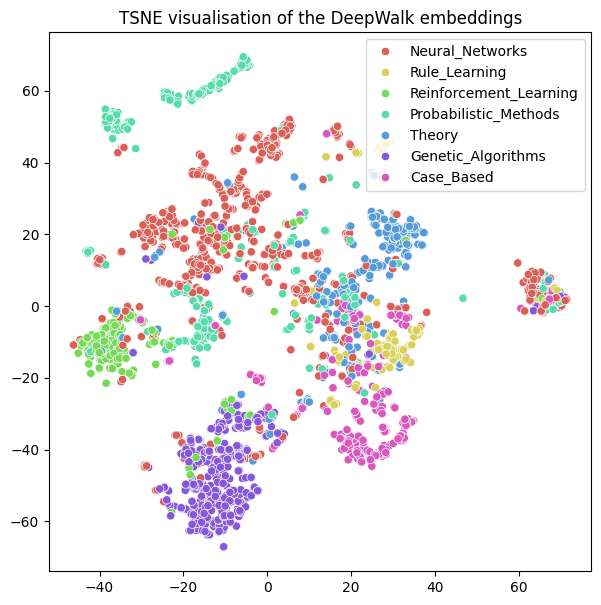

In [32]:
DeepWalk_embeddings = np.empty(shape=(n, n_dim))

for i in range(n):
    DeepWalk_embeddings[i] = model.wv[str(i)]


my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2)

vecs_pca = my_pca.fit_transform(DeepWalk_embeddings)
vecs_tsne = my_tsne.fit_transform(vecs_pca)

plt.figure(figsize=(7,7))
plt.title("TSNE visualisation of the DeepWalk embeddings")
colours = sns.color_palette("hls", len(np.unique(class_labels)))
sns.scatterplot(x=vecs_tsne[:,0], y=vecs_tsne[:,1], hue=class_labels, legend='full', palette=colours)
plt.show()

We will further evaluate the quality of the generated embeddings in a supervised node classification task. Specifically, we will feed to generated embeddings into a standard multinomial logisitic regression classifier.


>**Task 3:** Train a logistic regression classifier on the training data.
Then, use the classifier to make predictions for the test data (Hint: use the scikit-learn's implementation of the logistic regression classifier, which we imported above).
Compute the classification accuracy (Hint: use the ``accuracy_sore()`` function of scikit-learn).

In [33]:
X_train = DeepWalk_embeddings[idx_train,:]
X_test = DeepWalk_embeddings[idx_test,:]

clf = LogisticRegression()
clf.fit(X=X_train, y=class_labels_train)

preds = clf.predict(X_test)

print(f"Accuracy using DeepWalk embeddings {accuracy_score(class_labels_test, preds)}")

Accuracy using DeepWalk embeddings 0.8191881918819188


## 2) Graph Convolutional Networks

In the second part of the lab, we will focus on the problem of semi-supervised node classification using Graph Neural Networks (GNNs). Generally speaking, GNNs are neural networks that process graph-structured data, in contrast to MLPs processing vector data, CNNs processing structured data such as images and RNNs processing sequences.

GNNs follow a recursive neighborhood aggregation (or message passing) scheme, where each node aggregates feature vectors of its neighbors to compute its new feature vector.
After $k$ iterations of aggregation, a node is represented by its transformed feature vector, which captures the structural information within the node's $k$-hop neighborhood.


In node classification, we are given the class labels of some nodes, and the goal is to predict the class labels of the nodes of the test set using information from both the graph structure and the attributes of the nodes.

Given the adjacency matrix $\mathbf{A}$ of a graph, we will first normalise it as follows
\begin{equation*}
   \qquad\qquad\qquad\qquad \hat{\mathbf{A}} = (\mathbf{D}+\mathbf{I})^{-\frac{1}{2}} \; (\mathbf{A} +\mathbf{I}) \; (\mathbf{D}+\mathbf{I})^{-\frac{1}{2}}, \qquad\qquad\qquad\qquad(1)
\end{equation*}
where $\mathbf{D}$ is a diagonal matrix such that $\mathbf{D}_{ii} = \sum_j \mathbf{A}_{ij}$.
The above formula adds self-loops to the graph, and produces a symmetric normalised matrix.
This normalization trick, among other things, addresses numerical instabilities, which may lead to exploding/vanishing gradients when used in a deep neural network model.


>**Task 4:** Fill in the body of the ``normalise_adjacency()`` function that applies the normalisation trick in Equation (1). Note that the adjacency matrix is stored as a [sparse matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html). Use operations of the NumPy and SciPy libraries (e.g., ``identity()`` function of SciPy) to also produce a sparse normalised matrix.    



In [40]:
def normalise_adjacency(A: sp.csr_matrix) -> sp.csr_matrix:
    """Returns Â given A"""
    n = A.shape[0]
    A_with_self_loops = A + sp.identity(n)

    degrees = np.sum(A, axis=0) + 1
    inv_degrees = np.power(degrees, -0.5)
    D_inv = sp.diags(np.squeeze(np.asarray(inv_degrees)))

    A_normalised = D_inv @ A_with_self_loops @ D_inv

    return A_normalised

def sparse_to_torch_sparse(M: sp.csr_matrix) -> torch.Tensor:
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse_coo_tensor(indices, values, shape)

You will next implement a [Graph Convolutional Network (GCN)](https://arxiv.org/pdf/1609.02907.pdf) model that consists of three layers.
Let $\hat{\mathbf{A}}$ be the normalised adjacency matrix of the graph, and $\mathbf{X}$ a matrix whose $i^{th}$ row contains the feature vector of node $i$.
The first layer of the model is a message passing layer, and is defined as follows
\begin{equation*}
    \mathbf{Z}^0 = f(\hat{\mathbf{A}} \; \mathbf{X} \; \mathbf{W}^0 ),
\end{equation*}
where $\mathbf{W}^0$ is a matrix of trainable weights and $f$ is an activation function (e.g., ReLU, sigmoid, tanh).
Clearly, the new feature vector of each node is the sum of the feature vectors of its neighbors.
The second layer of the model is again a message passing layer
\begin{equation*}
    \mathbf{Z}^1 = f(\hat{\mathbf{A}} \; \mathbf{Z}^0 \; \mathbf{W}^1),
\end{equation*}
where $\mathbf{W}^1$ is a second matrix of trainable weights and $f$ is an activation function.
The two message passing layers are followed by a fully-connected layer which makes use of the softmax function to produce a probability distribution over the class labels
\begin{equation*}
    \hat{\mathbf{Y}} = \text{softmax}(\mathbf{Z}^1 \; \mathbf{W}^2),
\end{equation*}
where $\mathbf{W}^2$ is a third matrix of trainable weights.
Note that for clarity of presentation we have omitted biases.

We next discuss some practical implementation details.
Let $\mathbf{H} = f(\hat{\mathbf{A}} \; \mathbf{Z} \; \mathbf{W}^0 )$ be a message passing layer.
Clearly, to compute $\mathbf{H}$, we need to perform two matrix-matrix multiplications.
Since $\mathbf{W}$ corresponds to a matrix of trainable parameters, the first matrix-matrix multiplication (between $\mathbf{Z}$ and $\mathbf{W}$) can be defined as a fully-connected layer of the network.
Then, we can multiply $\hat{\mathbf{A}}$ with the output of the above operation and apply the nonlinear function to compute $\mathbf{H}$.

>**Task 5:** Implement the architecture presented above in the ``GCN()`` class.
More specifically, add the following layers:
>* a message passing layer with $h_1$ hidden units (i.e., $\mathbf{W}^0 \in \mathbb{R}^{d \times h_1}$) followed by a ReLU activation function
>* a dropout layer with $p_d$ ratio of dropped outputs
>* a message passing layer with $h_2$ hidden units (i.e., $\mathbf{W}^1 \in \mathbb{R}^{h_1 \times h_2}$) followed by a ReLU activation function
>* a fully-connected layer with $n_{class}$ units (i.e., $\mathbf{W}^2 \in \mathbb{R}^{h_2 \times n_{class}}$) followed by the log_softmax activation function

>Please return both the log_softmaxed output and the hidden states after the second layer, so that they can be visualised later on. Then, make use of our provided code to train this model on the cora dataset and visualise its hidden states.

>(Hint: You can perform a matrix-matrix multiplication using the ``torch.mm()`` function).


In [41]:

class GCN(nn.Module):
    """Simple GCN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GCN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        
        out = self.fc1(x_in)
        out = self.relu(torch.mm(adj, out))
        out = self.dropout(out)
        out = self.fc2(out)
        z2 = self.relu(torch.mm(adj, out))
        x = self.fc3(z2)
        return F.log_softmax(x, dim=1), z2

In [43]:
# Hyperparameters
epochs = 200
n_hidden_1 = 256
n_hidden_2 = 32
learning_rate = 0.01
dropout_rate = 0.5


# Creates the model and specifies the optimizer
model = GCN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

adj = normalise_adjacency(sp.csr_matrix(cora_adjacency)) 
adj = sparse_to_torch_sparse(sp.csr_matrix(cora_adjacency)).to(device)


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output,_ = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], class_labels_train)
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), class_labels_train.cpu().numpy())
    loss_train.backward()
    optimizer.step()

    
    model.eval()
    output,_ = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], class_labels_validation)
    acc_val = accuracy_score(torch.argmax(output[idx_val], dim=1).detach().cpu().numpy(), class_labels_validation.cpu().numpy())
    if epoch%10 == 0:
        print('Epoch: {:03d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(loss_train.item()),
              'acc_train: {:.4f}'.format(acc_train),
              'loss_val: {:.4f}'.format(loss_val.item()),
              'acc_val: {:.4f}'.format(acc_val),
              'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output, embeddings = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], class_labels_test)
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), class_labels_test.cpu().numpy())
    
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))

    return embeddings

# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
GCN_embeddings = test()

Epoch: 001 loss_train: 2.0043 acc_train: 0.0893 loss_val: 1.8570 acc_val: 0.2860 time: 0.1480s
Epoch: 011 loss_train: 1.2972 acc_train: 0.6761 loss_val: 1.2134 acc_val: 0.6974 time: 0.1995s
Epoch: 021 loss_train: 0.9473 acc_train: 0.8011 loss_val: 0.9301 acc_val: 0.7786 time: 0.1307s
Epoch: 031 loss_train: 0.7141 acc_train: 0.8239 loss_val: 0.7967 acc_val: 0.8118 time: 0.1678s
Epoch: 041 loss_train: 0.6906 acc_train: 0.8264 loss_val: 0.8050 acc_val: 0.8100 time: 0.1326s
Epoch: 051 loss_train: 0.5721 acc_train: 0.8510 loss_val: 0.7978 acc_val: 0.8044 time: 0.1304s
Epoch: 061 loss_train: 0.4742 acc_train: 0.8664 loss_val: 0.8925 acc_val: 0.7934 time: 0.1152s
Epoch: 071 loss_train: 0.4736 acc_train: 0.8695 loss_val: 0.8474 acc_val: 0.8155 time: 0.2391s
Epoch: 081 loss_train: 0.5066 acc_train: 0.8664 loss_val: 0.7940 acc_val: 0.8210 time: 0.1148s
Epoch: 091 loss_train: 0.5970 acc_train: 0.8676 loss_val: 1.0445 acc_val: 0.7952 time: 0.1164s
Epoch: 101 loss_train: 0.4864 acc_train: 0.8922 lo


We will now visualise the hidden states, which are fed into the final layer of the GCN architecture.

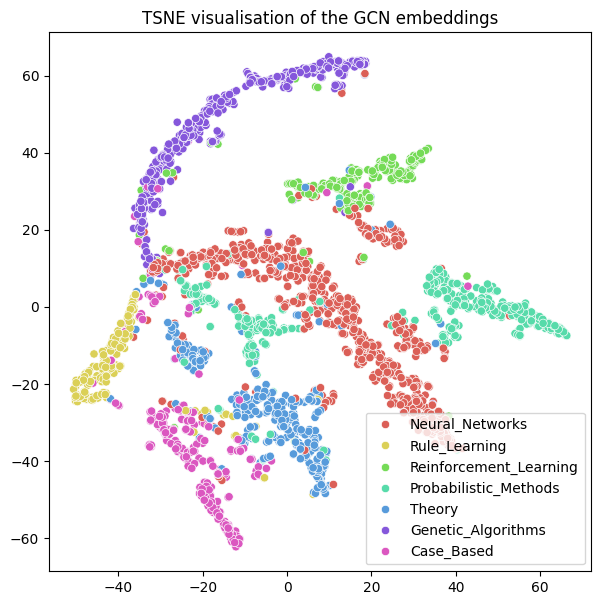

In [44]:
GCN_embeddings_local = GCN_embeddings.detach().cpu().numpy()


my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2)

vecs_pca = my_pca.fit_transform(GCN_embeddings_local)
vecs_tsne = my_tsne.fit_transform(vecs_pca)

plt.figure(figsize=(7,7))
plt.title("TSNE visualisation of the GCN embeddings")
colours = sns.color_palette("hls", len(np.unique(class_labels)))
sns.scatterplot(x=vecs_tsne[:,0], y=vecs_tsne[:,1], hue=class_labels, legend='full', palette=colours)


plt.show()

This concludes the taught part of the INF554 course. In the past weeks we had the pleasure to meet a wide range of machine and deep learning models ranging from linear models all the way to graph neural networks. For further context on what we have learned, we want to leave you with a famous quote of George Box:

> _"All models are wrong, but some are useful."_